用神经网络思想实现Logistic回归
欢迎来到你的第一个编程作业！ 你将学习如何建立逻辑回归分类器用来识别猫。 这项作业将引导你逐步了解神经网络的思维方式，同时磨练你对深度学习的直觉。

说明：
除非指令中明确要求使用，否则请勿在代码中使用循环（for / while）。

你将学习以下内容：

建立学习算法的一般架构，包括：
初始化参数
计算损失函数及其梯度
使用优化算法（梯度下降）
按正确的顺序将以上所有三个功能集成到一个主模型上。

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
import cv2
from PIL import Image
from scipy import ndimage
from lr_utils import load_dataset

%matplotlib inline

我们在图像数据集（训练和测试）的末尾添加了"_orig"，以便对其进行预处理。 预处理后，我们将得到train_set_x和test_set_x（标签train_set_y和test_set_y不需要任何预处理）。

train_set_x_orig和test_set_x_orig的每一行都是代表图像的数组。 你可以通过运行以下代码来可视化示例。 还可以随意更改index值并重新运行以查看其他图像。

y = [0], it's a 'non-cat' picture.


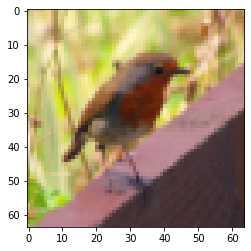

In [3]:
# Loading the data (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()
# Example of a picture
index = 10
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

深度学习中的许多报错都来自于矩阵/向量尺寸不匹配。 如果你可以保持矩阵/向量的尺寸不变，那么将消除大多错误。
请记住，“ train_set_x_orig”是一个维度为（m_train，num_px，num_px，3）的numpy数组。 
例如，你可以通过编写“ train_set_x_orig.shape[0]”来访问“ m_train”。
练习： 查找以下各项的值：
     m_train（训练集示例数量）
     m_test（测试集示例数量）
     num_px（=训练图像的高度=训练图像的宽度）

In [4]:
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


为了方便起见，你现在应该以维度(num_px * num_px * 3, 1)的numpy数组重塑维度（num_px，num_px，3）的图像。 
此后，我们的训练（和测试）数据集是一个numpy数组，其中每列代表一个展平的图像。 应该有m_train（和m_test）列。

练习： 重塑训练和测试数据集，以便将大小（num_px，num_px，3）的图像展平为单个形状的向量(num_px  num_px  3, 1)。
当你想将维度为（a，b，c，d）的矩阵X展平为形状为(bcd, a)的矩阵X_flatten时的一个技巧是：
X_flatten = X.reshape（X.shape [0]，-1）.T     ＃ 其中X.T是X的转置矩阵

In [5]:
# Reshape the training and test examples

### START CODE HERE ### (≈ 2 lines of code)
# reshape成209行，64*64列，再进行转置，这样就变成了64*64行，209列，得到X样本集合矩阵，就可以计算 W.T X + b了
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T
### END CODE HERE ###

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
sanity check after reshaping: [17 31 56 22 33]


为了表示彩色图像，必须为每个像素指定红、绿、蓝色通道（RGB），因此像素值实际上是一个从0到255的三个数字的向量。

机器学习中一个常见的预处理步骤是对数据集进行居中和标准化，这意味着你要从每个示例中减去整个numpy数组的均值，然后除以整个numpy数组的标准差。但是图片数据集则更为简单方便，并且只要将数据集的每一行除以255（像素通道的最大值），效果也差不多。

在训练模型期间，你将要乘以权重并向一些初始输入添加偏差以观察神经元的激活。然后，使用反向梯度传播以训练模型。但是，让特征具有相似的范围以至渐变不会爆炸是非常重要的。具体内容我们将在后面的教程中详细学习！

开始标准化我们的数据集吧！

你需要记住的内容：

预处理数据集的常见步骤是：

找出数据的尺寸和维度（m_train，m_test，num_px等）
重塑数据集，以使每个示例都是大小为（num_px \ num_px \ 3，1）的向量
“标准化”数据

In [6]:
# 使值落在(0,1)内，归一化
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

3-算法的一般架构：
    1.图像转换为向量
    2.归一化后计算WT X + b， 再通过激活函数得到yhat
    3.通过损失函数计算y与yhat的差距
    4.通过反向传播更新W和B（梯度下降）
    5.使用学习到的参数预测（测试集）
    6.分析结果并得出结论

In [7]:
def sigmoid(z):
    s = 1 / (1 + np.exp(-z))
    return s

In [8]:
def init_param_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    # 注意这里使用了元组创建
    w = np.zeros((dim, 1))
    b = 0
    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    return w, b

In [9]:
dim = 2
w, b = init_param_with_zeros(dim)
print ("w = " + str(w))
print ("b = " + str(b))

w = [[0.]
 [0.]]
b = 0


4.3- 前向和后向传播
现在，你的参数已初始化，你可以执行“向前”和“向后”传播步骤来学习参数。

练习： 实现函数propagate（）来计算损失函数及其梯度。

前向传播：
    1.得到X(matrix)
    2.计算A(a matrix consist of yhat) = sigmoid(a[0], a[1]...)
    3.计算损失函数J（交叉熵公式）

In [10]:
def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    Tips:
    - Write your code step by step for the propagation. np.log(), np.dot()
    """
    # X:(num_px * num_px, m)
    m = X.shape[1]
    A = sigmoid(np.dot(w.T, X) + b)
    cost = (-1 / m) * np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A)) 
    # BACKWARD PROPAGATION (TO FIND GRAD)
    ### START CODE HERE ### (≈ 2 lines of code)
    dw = 1 / m * np.dot(X, (A - Y).T)
    db = 1 / m * np.sum(A - Y)
    ### END CODE HERE ###
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost
w, b, X, Y = np.array([[1],[2]]), 2, np.array([[1,2],[3,4]]), np.array([[1,0]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[0.99993216]
 [1.99980262]]
db = 0.49993523062470574
cost = 6.000064773192205


d）优化函数
初始化参数。
计算损失函数及其梯度。
使用梯度下降来更新参数。
练习： 写下优化函数。 目标是通过最小化损失函数J来学习w和b。 

In [11]:
def optimize(w, b, X, Y, iterate_times, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to (relate to) the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    Tips:
    You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters. Use propagate().
        2) Update the parameters using gradient descent rule for w and b.
    """
    costs = []
    for i in range(iterate_times):
        grads, cost = propagate(w, b, X, Y)
        dw = grads["dw"]
        db = grads["db"]
        if i % 100 == 0:
            costs.append(cost)
        # update rule (≈ 2 lines of code)
        w = w - learning_rate * dw
        b = b - learning_rate * db
        # Print the cost every 100 training examples
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs
    
params, grads, costs = optimize(w, b, X, Y, iterate_times= 100, learning_rate = 0.009, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print(costs)

w = [[0.1124579 ]
 [0.23106775]]
b = 1.5593049248448891
dw = [[0.90158428]
 [1.76250842]]
db = 0.4304620716786828
[6.000064773192205]


实现预测分类函数，分为两个步骤。
    1.计算yhat = A = σ(W.T X + b)
    2.将A的项转换为0（如果激活<= 0.5）或1（如果激活> 0.5），并将预测结果存储在向量“ Y_prediction”中。 如果愿意，可以在for循环中使用if / else语句。

In [12]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    A = sigmoid(np.dot(w.T, X) + b)
    for i in range(m):
        if A[0, i] <= 0.5:
            Y_prediction[0, i] = 0
        else:
            Y_prediction[0, i] = 1
    assert(Y_prediction.shape == (1, m))
    return Y_prediction

print ("predictions = " + str(predict(w, b, X)))

predictions = [[1. 1.]]


5- 将所有功能合并到模型中
现在，将所有构件（在上一部分中实现的功能）以正确的顺序放在一起，从而得到整体的模型结构。

练习： 实现模型功能，使用以下符号：

     Y_prediction对测试集的预测
     Y_prediction_train对训练集的预测
     w，损失，optimize（）输出的梯度

In [13]:
def model(X_train, Y_train, X_test, Y_test, iterate_times = 2000, learning_rate = 0.5, print_cost = False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    ### START CODE HERE ###
    
    # initialize parameters with zeros (≈ 1 line of code)
    w, b = init_param_with_zeros(X_train.shape[0])

    # Gradient descent (≈ 1 line of code)
    parameters, grads, costs = optimize(w, b, X_train, Y_train, iterate_times, learning_rate, print_cost)

    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]

    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)
    ### END CODE HERE ###

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "iterate_times": iterate_times}
    
    return d

d = model(train_set_x, train_set_y, test_set_x, test_set_y, 2000, 0.0015, True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.571977
Cost after iteration 200: 0.528957
Cost after iteration 300: 0.497042
Cost after iteration 400: 0.471093
Cost after iteration 500: 0.449030
Cost after iteration 600: 0.429769
Cost after iteration 700: 0.412656
Cost after iteration 800: 0.397258
Cost after iteration 900: 0.383269
Cost after iteration 1000: 0.370460
Cost after iteration 1100: 0.358659
Cost after iteration 1200: 0.347727
Cost after iteration 1300: 0.337555
Cost after iteration 1400: 0.328052
Cost after iteration 1500: 0.319144
Cost after iteration 1600: 0.310767
Cost after iteration 1700: 0.302869
Cost after iteration 1800: 0.295403
Cost after iteration 1900: 0.288331
train accuracy: 93.77990430622009 %
test accuracy: 74.0 %


y = 1, you predicted that it is a "cat" picture.


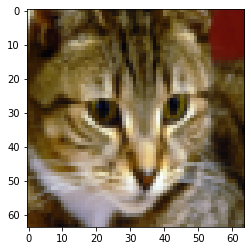

In [14]:
index = 15
plt.imshow(test_set_x[:,index].reshape((num_px, num_px, 3)))
print ("y = " + str(test_set_y[0,index]) + ", you predicted that it is a \"" + classes[int(d["Y_prediction_test"][0,index])].decode("utf-8") +  "\" picture.")

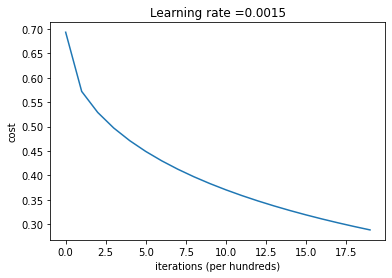

In [15]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

测试自己的猫猫！

y = 1.0, your algorithm predicts a "cat" picture.


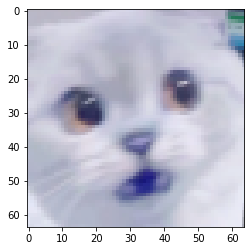

In [16]:
pic = "E:/VSCodeWorkSpace/dl_start/dl_homework/lesson_1/week_4/img/cat3.jpg"
img = cv2.imread(pic)
resized_img = cv2.resize(img, (num_px, num_px), interpolation=cv2.INTER_AREA)
plt.imshow(resized_img)
# cv2.imshow("cat", resized_img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
# my_image = scipy.misc.imresize(image, size=(num_px,num_px)).reshape((1, num_px*num_px*3)).T
arr_img = np.array(resized_img)
vec_img = arr_img.reshape((1, num_px*num_px*3)).T
my_predict_image = predict(d["w"], d["b"], vec_img)
print("y = " + str(np.squeeze(my_predict_image)) + ", your algorithm predicts a \"" + classes[int(np.squeeze(my_predict_image)),].decode("utf-8") +  "\" picture.")